In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from dynamics_env.dynamics_rocket import Dynamics

In [2]:
seed=0
Myr_to_s = 86400 * 365 * 1e6
start=None
rocket_mass=433100
destination_type='radius'
destination_params=None
capture_radius=6371e2
orbit_duration=5000
orbit_timesteps=1000
dry_mass = rocket_mass * (1 - 0.9)
num_steps = int(orbit_timesteps)
total_timesteps = 8000
v_e=3000e3
def make_env(seed):
    def thunk():
        env = Dynamics(hyperparameters={
            'planetary_model_list':['point_source', 'point_source', 'point_source'],
            'planetary_model_kwargs_list':[{'M':2e30, 'period':1e10, 'orbit_radius':0, 'phase':0}, # sun
                                            {'M':1.898e27, 'period':11.86, 'orbit_radius':7.7866e11, 'phase':0.785}, # jupiter
                                            {'M':5.972e24, 'period':1, 'orbit_radius':1.496e11, 'phase':3.945}], # earth
            'seed':seed,
            'max_engine_thrust':7500e3,
        })
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk

env = make_env(seed=seed)()

episodic_reward = 0
if start == None:
    leo_distance = 6371e3 + 300e3 # 300e3 m
    leo_speed = 7.7e3 # 7.7e3 m/s
    earth_orbital_speed = 2.977e4 # m/s
    launch_theta = np.pi / 2 # np.random.rand() * 2 * np.pi * 0
    earth_phase, earth_orbit_radius = env.planetary_models[-1].phase, env.planetary_models[-1].orbit_radius
    launch_position = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_distance + np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius
    launch_velocity = np.array([np.cos(launch_theta), np.sin(launch_theta)]) * leo_speed + env.planetary_models[-1].get_velocity(0, earth_orbital_speed)
    launch_mass = np.array([rocket_mass])
    init_params = np.concat([launch_position, launch_velocity, launch_mass])
else: init_params = np.array(start)
if destination_type == 'radius':
    if destination_params == None:
        destination_radius = 35768e3 # geocentric orbit radius (easy)
        # destination_radius = 35768e4 # 
        start_radius = 6371e3 + 300e3
    else:
        destination_radius = destination_params[0]
        start_radius = destination_params[1]
elif destination_type == 'destination_planet':
    if destination_params == None:
        destination_planet_index = len(env.planetary_models)-1
        destination_planet_radius = 6051.8e3 # m (venus)
    else:
        destination_planet_index = destination_params[0]
        destination_planet_radius = destination_params[1]
    start_planet_distance = np.linalg.norm(init_params[:2] - env.planetary_models[destination_planet_index].get_position())
elif destination_type == 'destination':
    if destination_params == None:
        destination_distance = 3 * 1.496e11 # 3au in m
        destination_theta = np.random.rand() * 2 * np.pi # in rad
        destination_radius = 6371e3 # earth radius in m
    else:
        destination_distance = destination_params[0]
        destination_theta = destination_params[1]
        destination_radius = destination_params[2]
    start_destination_distance = np.linalg.norm(init_params[:2] - np.linalg.norm(np.array([np.cos(destination_theta), np.sin(destination_theta)]) * destination_distance))
    destination_coords = np.array([np.cos(destination_theta), np.sin(destination_theta)]) * destination_distance + np.array([np.cos(earth_phase), np.sin(earth_phase)]) * earth_orbit_radius

In [3]:
def reward_function(pos, prev_pos, mass, prev_mass, t):
    if destination_type == 'radius':
        earth_position = env.planetary_models[-1].get_position(t)
        current_radius = np.linalg.norm(pos - earth_position, axis=-1)
        prev_radius = np.linalg.norm(prev_pos - earth_position, axis=-1)
        consistent_reward = (current_radius - prev_radius) / (destination_radius - start_radius) + (mass - prev_mass) / rocket_mass
        completion_reward = current_radius >= destination_radius
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position(t)
        consistent_reward = (start_planet_distance - np.linalg.norm(planet_position - pos, axis=-1)) / start_planet_distance + (mass - prev_mass) / rocket_mass
        completion_reward = np.linalg.norm(pos - planet_position, axis=-1) < destination_planet_radius
    elif destination_type == 'destination':
        consistent_reward = (start_destination_distance - np.linalg.norm(destination_coords - pos, axis=-1)) / start_destination_distance + (mass - prev_mass) / rocket_mass
        completion_reward = np.linalg.norm(pos - destination_coords, axis=-1) < destination_radius
    # print(consistent_reward)
    # print(completion_reward)
    return consistent_reward + completion_reward

def done_function(pos, t):
    if destination_type == 'radius':
        earth_position = env.planetary_models[-1].get_position(t)
        current_radius = np.linalg.norm(pos - earth_position)
        completion_reward = current_radius >= destination_radius
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position(t)
        completion_reward = np.linalg.norm(pos - planet_position) < destination_planet_radius
    elif destination_type == 'destination':
        completion_reward = np.linalg.norm(pos - destination_coords) < destination_radius
    return completion_reward

def event_dest_reached(t, y, thrust):
    pos = y[:2]
    if destination_type == 'radius':
        earth_position = env.planetary_models[-1].get_position(t)
        current_radius = np.linalg.norm(pos - earth_position)
        completion = 0 if current_radius >= destination_radius else 1
    elif destination_type == 'destination_planet':
        planet_position = env.planetary_models[destination_planet_index].get_position(t)
        completion = 0 if np.linalg.norm(pos - planet_position) < destination_planet_radius else 1
    elif destination_type == 'destination':
        completion = 0 if np.linalg.norm(pos - destination_coords) < destination_radius else 1
    return completion
event_dest_reached.terminal = True
def rocket_captured(t, y, thrust):
    pos = y[:2]
    min_dist = np.inf
    for model in env.planetary_models:
        dist = np.linalg.norm(pos - model.get_position(t))
        min_dist = min(min_dist, dist)
    return min_dist - capture_radius
rocket_captured.terminal = True

def rocket_function(t, y, thrust):
    # state packaging
    pos = y[:2]
    vel = y[2:4]
    mass = y[-1:]
    a_gravity = env.get_acceleration(np.concat([pos, np.array([t])]))
    # rocket science
    mdot = -np.linalg.norm(thrust, axis=-1) / v_e # in m/s^2
    delta_m = mdot * orbit_duration / orbit_timesteps
    if (mass - delta_m) < dry_mass:
        a_thrust = np.zeros_like(thrust)
        mdot = 0
    else:
        a_thrust = thrust / mass
    # derivatives for integrator
    dydt = np.zeros_like(y)
    dydt[:2] = vel
    dydt[2:4] = a_gravity + a_thrust
    dydt[4] = mdot
    return dydt

In [4]:
delta_t = orbit_duration / orbit_timesteps
prev_logprob = None
done = False
# state = torch.tensor(init_params, dtype=torch.float32).to(device)

# observations = torch.zeros((num_steps,)+env.observation_space.shape, dtype=torch.float32).to(device)
# actions = torch.zeros((num_steps,)+env.action_space.shape, dtype=torch.float32).to(device)
# logprobs = torch.zeros((num_steps,)+env.action_space.shape, dtype=torch.float32).to(device)
# rewards = torch.zeros((num_steps,), dtype=torch.float32).to(device)
# dones = torch.zeros((num_steps,), dtype=torch.float32).to(device)
# values = torch.zeros((num_steps,), dtype=torch.float32).to(device)
clip_fracs = []
y0 = init_params
t = 0
trajectory = [init_params]
times = [t]
termination_status = 0
termination_y_events = None
for j in range(orbit_timesteps):
    # preparing args for solve_ivp
    pos, vel, mass = y0[:2], y0[2:4], y0[-1:]
    a_gravity = env.get_acceleration(np.concat([pos, np.array([t])]))
    # state = env._normalise_state(torch.tensor(np.concat([pos, vel, a_gravity, mass]), dtype=torch.float32, device=device)).float()
    # with torch.no_grad():
    #     action_means, action_stds = actor(state)
    # value = critic(state).flatten()
    # dist = torch.distributions.Normal(action_means, action_stds)
    action = np.array([1,1])
    # logprob = dist.log_prob(action)
    thrust = env._process_actions(action) # in N (kg m/s^2)
    # orbit step integration
    orbit = solve_ivp(rocket_function, t_span=(t, t + delta_t), y0=y0, t_eval=[t + delta_t], events=[rocket_captured, event_dest_reached], args=(thrust,))
    if orbit.status == 1: 
        if orbit.t_events[0] != None: 
            termination_status = 1
            termination_y_events = orbit.y_events[0][0]
        else: 
            termination_status = 2
            termination_y_events = orbit.y_events[1][0]
        break
    # PPO
    # observations[j] = state
    # actions[j] = action
    # logprobs[j] = logprob
    # dones[j] = torch.tensor(done_function(pos), dtype=torch.float32).to(device)
    # reward = reward_function(orbit.y[:2,-1], pos, orbit.y[-1:,-1], mass)
    # rewards[j] = torch.tensor(reward, dtype=torch.float32, device=device)
    # values[j] = value
    # preparing for next orbit step integration
    y0 = orbit.y[:,-1]
    t = t + delta_t
    trajectory.append(y0)
    times.append(t)

/tmp/ipykernel_74813/3144288449.py:34: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if orbit.t_events[0] != None:


In [5]:
orbit = np.array(trajectory).transpose()

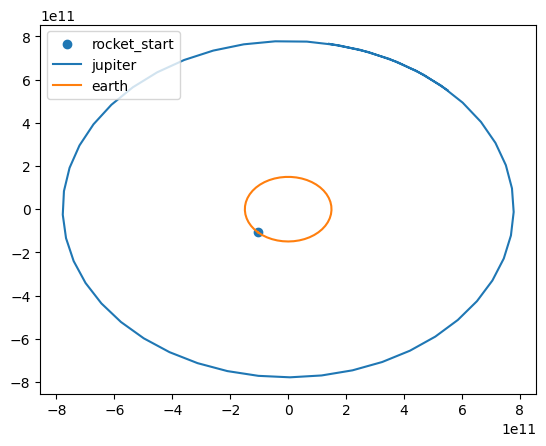

In [6]:
plot, axes = plt.subplots(1,1)
# axes.plot(orbit[0], orbit[1], label='rocket')
axes.scatter(orbit[0,0], orbit[1,0], label='rocket_start')
jupiter_orbit = env.planetary_models[1].get_position(t=np.linspace(13 * Myr_to_s / 1e6, orbit_timesteps))
axes.plot(jupiter_orbit[0], jupiter_orbit[1], label='jupiter')
earth_orbit = env.planetary_models[2].get_position(t=np.linspace(1 * Myr_to_s / 1e6, orbit_timesteps))
axes.plot(earth_orbit[0], earth_orbit[1], label='earth')
axes.legend()

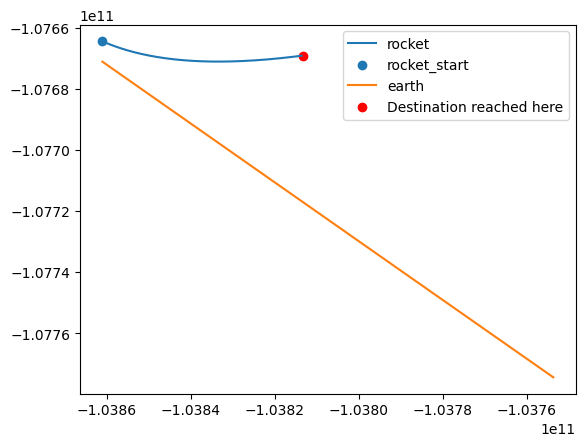

In [7]:
plot, axes = plt.subplots(1,1)
axes.plot(orbit[0], orbit[1], label='rocket')
axes.scatter(orbit[0,0], orbit[1,0], label='rocket_start')
earth_orbit = env.planetary_models[2].get_position(t=np.linspace(0, orbit_duration, orbit_timesteps))
axes.plot(earth_orbit[0], earth_orbit[1], label='earth')
if termination_status:
    termination_message = 'Rocket captured here' if termination_status == 1 else 'Destination reached here'
    axes.scatter(termination_y_events[0], termination_y_events[1], label=termination_message, c='r')
axes.legend()

In [8]:
orbit

array([[-1.03861055e+11, -1.03860948e+11, -1.03860840e+11, ...,
        -1.03814093e+11, -1.03813865e+11, -1.03813637e+11],
       [-1.07664315e+11, -1.07664380e+11, -1.07664444e+11, ...,
        -1.07669115e+11, -1.07669075e+11, -1.07669034e+11],
       [ 2.14262384e+04,  2.15128459e+04,  2.15994549e+04, ...,
         4.54730383e+04,  4.55598864e+04,  4.56467445e+04],
       [-1.29680722e+04, -1.29259867e+04, -1.28833852e+04, ...,
         7.93999086e+03,  8.02619974e+03,  8.11242754e+03],
       [ 4.33100000e+05,  4.33082322e+05,  4.33064645e+05, ...,
         4.28132575e+05,  4.28114897e+05,  4.28097220e+05]])